In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import hdf5plugin
import tables
import gffutils
import tqdm
import sqlite3

# Apr 5 Research Update

In [2]:
source_dir = "/Users/7408588/Documents/School.nosync/projects/58genomes/ncbi_dataset/data/"
with open(source_dir + 'linking_dict.json', 'r') as ifile:
    linking_dict = json.load(ifile)
curated_genome_frame = pd.read_csv(source_dir + 'curated_genome_frame.csv')

In [10]:
genome_filename = curated_genome_frame['Filename'].to_numpy()
species = np.zeros(genome_filename.shape).astype(str)
grab_species = np.vectorize(lambda x: x.split('_')[1] if (x.split('_')[1] != 'sp' and x.split('_')[1] != 'subsp') else 'no subspecies')
species_distr, counts = np.unique(grab_species(genome_filename), return_counts=True)
species_distr = np.append(species_distr, ['cnambio', 'wsucf'])
counts = np.append(counts, [1, 1])
sorted_idx = np.argsort(species_distr)
species_distr = species_distr[sorted_idx]
counts = counts[sorted_idx]

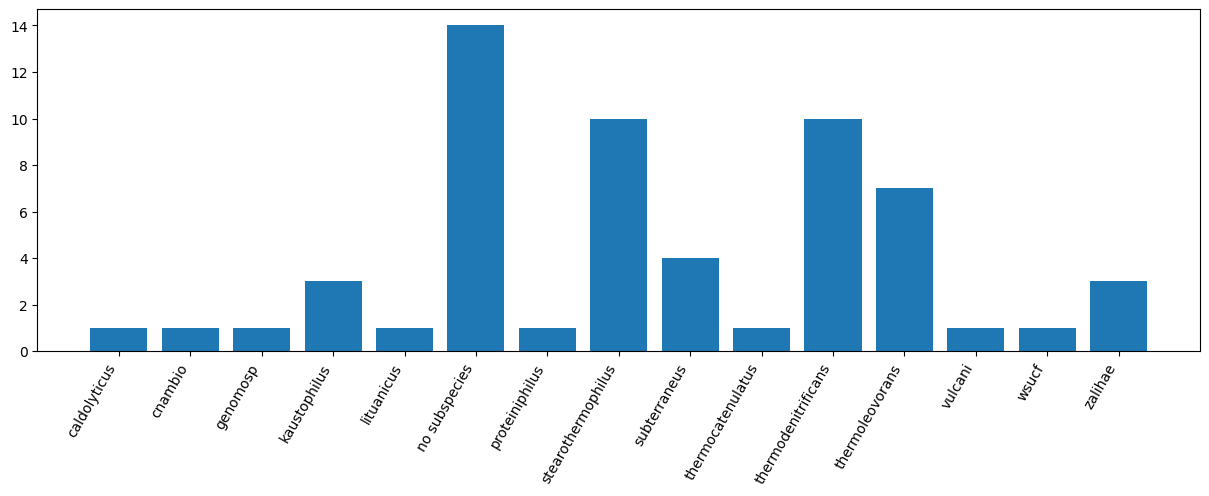

In [11]:
fig, ax = plt.subplots(figsize=(len(species_distr),9))
plt.subplots_adjust(bottom=0.5)
ax.bar(species_distr, counts, label=species_distr)
# ax.hist(final['Organism Scientific Name'].to_numpy(),
#         bins=np.unique(final['Organism Scientific Name'].to_numpy()).shape[0],
#         linewidth=0.5, edgecolor="white")
plt.xticks(rotation=60, ha='right')
fig.savefig(source_dir + 'assemblies_graph.jpeg', dpi=900)

# Apr 15 Tasks

Get Stats for:
\# of genes
\# of families
\# of cloud, persistent and shell genes

list of persistent genomes
list of genomes

In [65]:
# open using Tables
h5py_file_dir = "/Users/7408588/Documents/School.nosync/projects/58genomes/ppan_run/"
h5py_file = tables.open_file(h5py_file_dir + "58genomes.h5", driver="H5FD_CORE")

In [66]:
def create_info_dict(info_group: tables.group.Group):
    """
    Read the pangenome content

    :param info_group: group in pangenome HDF5 file containing information about pangenome
    """
    attributes = info_group._v_attrs._f_list()

    info_dict = {"Genes": int(info_group._v_attrs['numberOfGenes'])}

    if "numberOfGenomes" in attributes:
        info_dict["Genomes"] = int(info_group._v_attrs['numberOfGenomes'])

    if "numberOfClusters" in attributes:
        info_dict["Families"] = int(info_group._v_attrs['numberOfClusters'])

    if "numberOfEdges" in attributes:
        info_dict["Edges"] = int(info_group._v_attrs['numberOfEdges'])

    if 'numberOfCloud' in attributes:  # then all the others are there

        persistent_stat = {"Family_count": int(info_group._v_attrs['numberOfPersistent'])}
        persistent_stat.update(info_group._v_attrs['persistentStats'])
        info_dict["Persistent"] = persistent_stat

        shell_stat = {"Family_count": int(info_group._v_attrs['numberOfShell'])}
        shell_stat.update(info_group._v_attrs['shellStats'])
        info_dict["Shell"] = shell_stat

        cloud_stat = {"Family_count": int(info_group._v_attrs['numberOfCloud'])}
        cloud_stat.update(info_group._v_attrs['cloudStats'])
        info_dict["Cloud"] = cloud_stat

        info_dict["Number_of_partitions"] = int(info_group._v_attrs['numberOfPartitions'])

        if info_group._v_attrs['numberOfPartitions'] != 3:
            subpartition_stat = {f"Shell_{key}": int(val) for key, val in
                                 info_group._v_attrs['numberOfSubpartitions'].items()}
            info_dict.update(subpartition_stat)

    if 'genomes_fluidity' in attributes:
        info_dict["Genomes_fluidity"] = {key: round(val, 3) for key, val in
                                         info_group._v_attrs['genomes_fluidity'].items()}

    if 'family_fluidity' in attributes:
        info_dict["Family_fluidity"] = info_group._v_attrs['family_fluidity']

    if 'numberOfRGP' in attributes:
        info_dict["RGP"] = int(info_group._v_attrs['numberOfRGP'])

    if 'numberOfSpots' in attributes:
        info_dict["Spots"] = int(info_group._v_attrs['numberOfSpots'])

    if 'numberOfModules' in attributes:
        info_dict["Modules"] = {
            'Number_of_modules': int(info_group._v_attrs['numberOfModules']),
            'Families_in_Modules': int(info_group._v_attrs['numberOfFamiliesInModules']),
            'Partition_composition': {
                "Persistent": info_group._v_attrs['PersistentSpecInModules']['percent'],
                "Shell": info_group._v_attrs['ShellSpecInModules']['percent'],
                "Cloud": info_group._v_attrs['CloudSpecInModules']['percent']
            }
        }
    return info_dict
pangenome_info = create_info_dict(h5py_file.root.info)
with open(h5py_file_dir + 'pangenome_stats.json', 'w') as json_ofile:
    json.dump(pangenome_info, json_ofile)
    
for x in pangenome_info.keys():
    print(f' {x}: {pangenome_info[x]}')

 Genes: 213499
 Families: 12929
 Edges: 28386
 Persistent: {'Family_count': 2253, 'min': 0.78, 'max': 1.0, 'sd': 0.03, 'mean': 0.98}
 Shell: {'Family_count': 2332, 'min': 0.1, 'max': 0.93, 'sd': 0.21, 'mean': 0.35}
 Cloud: {'Family_count': 8344, 'min': 0.02, 'max': 0.12, 'sd': 0.02, 'mean': 0.03}
 Number_of_partitions: 3
 RGP: 3448
 Spots: 436


In [35]:
h5py_file.close()

In [67]:
pangenome_filename = [x for x in os.listdir(h5py_file_dir) if '.h5' in x][0]
print(pangenome_filename)

58genomes.h5


In [68]:
print([x for x in h5py_file.walk_groups('/')])

[/ (RootGroup) ''
  children := ['annotations' (Group), 'info' (Group), 'status' (Group), 'RGP' (Table), 'edges' (Table), 'geneFamilies' (Table), 'geneFamiliesInfo' (Table), 'geneSequences' (Table), 'spots' (Table)], /annotations (Group) "Annotations of the pangenome's organisms"
  children := ['genes' (Table)], /info (Group) "Informations about the pangenome's content"
  children := [], /status (Group) "Statuses of the pangenome's content"
  children := []]


In [69]:
node_list = h5py_file.list_nodes('/')
print(node_list)

[/RGP (Table(72884,)bitshuffle, blosc:zstd(1)) ''
  description := {
  "RGP": StringCol(itemsize=64, shape=(), dflt=b'', pos=0),
  "gene": StringCol(itemsize=14, shape=(), dflt=b'', pos=1)}
  byteorder := 'irrelevant'
  chunkshape := (840,), /annotations (Group) "Annotations of the pangenome's organisms"
  children := ['genes' (Table)], /edges (Table(208241,)bitshuffle, blosc:zstd(1)) ''
  description := {
  "geneSource": StringCol(itemsize=14, shape=(), dflt=b'', pos=0),
  "geneTarget": StringCol(itemsize=14, shape=(), dflt=b'', pos=1)}
  byteorder := 'irrelevant'
  chunkshape := (2340,), /geneFamilies (Table(213499,)bitshuffle, blosc:zstd(1)) ''
  description := {
  "gene": StringCol(itemsize=14, shape=(), dflt=b'', pos=0),
  "geneFam": StringCol(itemsize=14, shape=(), dflt=b'', pos=1)}
  byteorder := 'irrelevant'
  chunkshape := (2340,), /geneFamiliesInfo (Table(12929,)bitshuffle, blosc:zstd(1)) ''
  description := {
  "name": StringCol(itemsize=14, shape=(), dflt=b'', pos=0),
  "pa

In [70]:
genes_table = h5py_file.get_node('/geneFamilies').read()
print(genes_table.shape)
print(type(genes_table[0]))

(213499,)
<class 'numpy.void'>


In [3]:
df = pd.read_csv("/Users/7408588/Documents/School.nosync/projects/58genomes/trimmed_matrix_files/biological.csv")
gene_sum = np.sum(df.loc[:, "Count"])
df.loc[:, "Score (% of genes involved)"] = df.loc[:, "Count"].to_numpy()*100/gene_sum
df.sort_values(by=['Score (% of genes involved)'], ascending=False, inplace=True)

In [4]:
df.head()

,Gene Ontology ID,Protein Name,UniProtKB,Gene Ontology Classification,Classification Value,Count,Score (% of genes involved)
0,GO:0006635,Long-chain-fatty-acid--CoA ligase,O07610,Biological Process,fatty acid beta-oxidation,312,0.169809
1,GO:0030497,3-oxoacyl-[acyl-carrier-protein] reductase FabG,P99093,Biological Process,fatty acid elongation,304,0.165455
2,GO:0042941,High-affinity branched-chain amino acid transp...,P0AEX7,Biological Process,D-alanine transport,213,0.115927
4,GO:0015823,High-affinity branched-chain amino acid transp...,P0AEX7,Biological Process,phenylalanine transport,213,0.115927
5,GO:0098713,High-affinity branched-chain amino acid transp...,P0AEX7,Biological Process,leucine import across plasma membrane,213,0.115927


In [2]:
trimmed_matrix = pd.read_csv("/Users/7408588/Documents/School.nosync/projects/58genomes/trimmed_matrix_files/genes.csv")
gene_ont = pd.read_csv("/Users/7408588/Documents/School.nosync/projects/58genomes/trimmed_matrix_files/go_ids.csv")


/var/folders/mn/t0hb8mrx44vdz_nmtvs51hkrkq821d/T/ipykernel_49223/2552710501.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  trimmed_matrix = pd.read_csv("/Users/7408588/Documents/School.nosync/projects/58genomes/trimmed_matrix_files/genes.csv")


In [6]:
def condense_to_db(filename:str, path:str, trimmed_matrix:pd.DataFrame, gene_ont:pd.DataFrame):
    cnx = sqlite3.connect(":memory:")
    
    genes_table = trimmed_matrix.loc[:, ['Gene ID', 'Organism', 'Gene Family']].set_index('Gene ID')
    genes_table.to_sql('genes', cnx, if_exists='fail')
    
    organism_link = trimmed_matrix.loc[trimmed_matrix['Gene ID'] == trimmed_matrix['Gene Family'], ['Organism', 'Genome ID']]
    organism_link = organism_link.drop_duplicates(subset=['Organism']).set_index('Organism')
    organism_link.to_sql('organisms', cnx, if_exists='fail')
    
    gene_families_table = trimmed_matrix.drop_duplicates(subset=['Gene Family']).set_index('Gene Family').loc[:, 
                          ['Annotation', 'Partition', '# Isolates', '# Sequences', 'Avg seqs/isolate', 'UniProtKB']]
    gene_families_table.to_sql('gene_families', cnx, if_exists='fail')
    
    go_processes = gene_ont.set_index('Gene Ontology ID').loc[:, ['Gene Ontology Classification', 'Classification Value', 'UniProtKB']]
    go_processes.to_sql('go_processes', cnx, if_exists='fail')
    
    uniprots = gene_ont.drop_duplicates(subset=['UniProtKB']).set_index('UniProtKB').loc[:,
               ['Protein Name', 'Count']]
    uniprots.to_sql('uniprot_proteins', cnx, if_exists='fail')
    
    if os.path.exists(f"{path}/{filename}"):
        os.remove(f"{path}/{filename}")
    cnx.execute("vacuum main into " +  f"\'{path}/{filename}\'")
    cnx.close()

condense_to_db(filename="test.db", path="/Users/7408588/Documents/School.nosync/projects/58genomes/trimmed_matrix_files/",
               trimmed_matrix=trimmed_matrix, gene_ont=gene_ont)

